<a href="https://colab.research.google.com/github/JihoKim1108/handson-ml2/blob/master/%EC%B1%95%ED%84%B03_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3.1 MNIST

In [ ]:
# MNIST 데이터셋: 숫자 이미지
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [ ]:
# 배열 살펴보기
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [ ]:
y.shape

(70000,)

* 이미지 70000개, 각 이미지 784개의 특성
* 이미지가 28X28 픽셀이기 때문

* 데이터셋에서 이미지 하나 확인

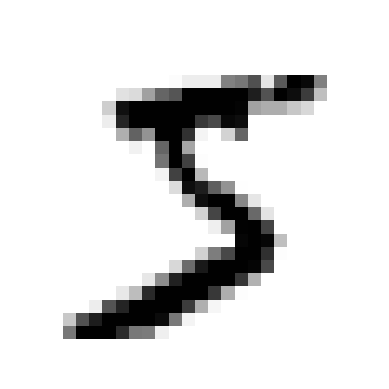

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

* 5로 보임. 실제 레이블 확인

In [ ]:
y[0]

'5'

* 레이블이 문자열이므로 y를 정수로 변환

In [ ]:
import numpy as np
y = y.astype(np.uint8)

* 데이터를 자세히 조사하기 전에 항상 테스트 세트를 만들고 따로 떼어놓아야 함
* 이미 MNIST 데이터셋은 이미 훈련 세트와 테스트 세트로 나누어 놓았음

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

* 훈련 세트는 이미 섞여 있어서 모든 교차 검증 폴드를 비슷하게 만든다
* 어떤 학습 알고리즘은 훈련 샘플의 순서에 민감해서 비슷한 샘플이 연이어 나타나면 성능이 나빠진다
 * SGD가 샘플을 섞어야 하는 대표적인 경우

* 하지만 어떤 경우는 섞는 것이 좋지 않다
 * 주식가격, 날씨 예보 같은 시계열 데이터를 다룰 때

# 3.2 이진 분류기 훈련

* 문제를 단순화해서 하나의 숫자 5만 식별해보자
* 이진 분류기(binary classifier)의 한 예시

In [ ]:
# 타깃 벡터 만들기
y_train_5 = (y_train == 5) # 5는 True고, 다른 숫자는 모두 False
y_test_5 = (y_test == 5)

* 확률적 경사 하강법(Stochastic Gradient Descent, SGD) 분류기
 * 매우 큰 데이터셋을 효율적으로 처리
 * 한 번에 하나씩 훈련 샘플을 독립적으로 처리
 * 그래서 온라인 학습에 잘 들어맞음
 * 훈련하는 데 무작위성을 사용(stochaastic)


In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [ ]:
sgd_clf.predict([some_digit])

array([ True])

# 3.3 성능 측정

* 분류기 평가는 회귀 모델보다 훨씬 어렵다
* 사용가능한 성능 지표가 많다

교차 검증을 사용한 정확도 측정
> 교차 검증 구현
 * 가끔 사이킷런이 제공하는 기능보다 교차 검증 과정을 더 많이 제어해야 할 필요가 있다. 이때는 교차 검증 기능을 직접 구현하면 된다
 * 다음 코드는 cross_val_score() 함수와 거의 같은 작업을 수행하고 동일한 결과를 출력한다

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf) # 기존 분류기의 복사본 만들기
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    # 순서가 중요할 듯?

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


* cross_val_score() 함수로 폴드가 3개인 k-겹 교차 검증을 사용해 SGDClassifier 모델을 평가

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

* 모든 이미지를 '5아님' 클래스로 분류하는 더미 분류기를 만들어 비교

In [ ]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [ ]:
# 정확도 추측
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

* 이미지의 10% 정도만 숫자 5이기 때문에 무조건 '5아님'으로 예측하면 정확히 맞출 확률이 90%이다
* 이 예제는 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유를 보여준다
 * 특히 불균형한 데이터셋을 다룰 때 더욱 그렇다(어떤 클래스가 다른 것보다 월들히 많은 경우)

오차 행렬

* 오차 행렬(confusion matrix)
> * 분류기의 성능을 평가하는 더 좋은 방법
  * 기본적 아이디어: 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것
  * 예) 분류기가 숫자 5의 이미지를 3으로 잘못 분류한 횟수를 알고 싶다면 오차 행렬의 5행 3열을 보면 된다

* 오차 행렬 만들기
> * 실제 타깃과 비교할 수 있도록 먼저 예측값을 만들어야 함
  * cross_val_predict() 사용

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

* cross_val_score() 함수처럼 cross_val_predict() 함수는 k-겹 교차 검증을 수행하지만 평가 점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측을 반환

* 즉, 훈련 세트의 모든 샘플에 대해 깨끗한 예측을 얻게 됨('깨끗하다': 모델이 훈련하는 동안 보지 못했던 데이터에 대해 예측했다는 의미

* confusion_matrix() 함수 사용해 오차 행렬 만듬. 타깃 클래스, 예측 클래스 넣고 호출

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

* 오차 행렬의 행: 실제 클래스
* 오차 행렬의 열: 예측한 클래스
* 이 행렬의 첫 번째 행은 '5 아님'이미지(음성 클래스)에 대한 것
> * 53892개를 '5 아님'으로 정확하게 분류('진짜 음성'이라고 함)
  * 나머지 687개는 '5'라고 잘못 분류('거짓 양성')

* 두 번째 행은 '5' 이미지(양성 클래스)에 대한 것
> * 1891개를 '5 아님'으로 잘못 분류('거짓 음성')
  * 나머지 3530을 정확히 '5'라고 분류('진짜 양성')

* 완벽한 분류기라면 진짜 양성과 진짜 음성만 가지고 있을 것이므로 오차 행렬의 주대각선(왼쪽 위에서 오른쪽 아래로)만 0이 아닌 값이 된다


In [ ]:
# 완벽한 분류기 예시
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

* 더 요약된 지표 필요할 때 살펴볼 만한 것
* 정밀도(precision): 모델이 양성이라고 예측한 샘플 중 실제로 양성인 샘플의 비율
> * 양성으로 예측한 샘플이 실제로 양성인 경우에만 점수를 부여
  * 양성 샘플을 놓치는 경우가 발생할 수 있다
  * 정밀도는 재현율이라는 또 다른 지표와 같이 사용하는 것이 일반적
* 재현율(recall) 또는 민감도(sensitivity) 또는 진짜 양성 비율(true positive rate, TPR): 모델이 양성 클래스를 얼마나 잘 찾아내는지를 측정. 즉, 전체 양성 샘플 중에서 모델이 양성으로 정확하게 예측한 샘플의 비율
> * 실제 양성 샘플을 모두 찾아내는 것에 중점
  * 이 과정에서 음성 샘플을 양성으로 잘못 분류하는 경우가 발생할 수 있다

* 정밀도와 재현율

In [ ]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [ ]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

* F1 점수: 정밀도와 재현율의 조화 평균(harmonic mean)
>* 정밀도와 재현율이 모두 높을 때 최대가 된다
 * 정밀도와 재현율 사이의 균형을 맞추는 데 중점을 둔 지표
 * 이런 특성 때문에 F1 점수는 양성 샘플의 수가 적거나 가짜 양성과 가짜 음성 중 어느 하나를 특별히 피해야 하는 상황에서 유용하게 사용 가능하다!

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

* 정밀도/재현율 트레이드오프: 정밀도를 올리면 재현율이 줄고 그 반대도 마찬가지
* 어떤 지표가 더 중요한지 생각해 보자

* SGDClassifier가 분류를 어떻게 결정하는지 살펴보자
> * 이 분류기는 결정 함수(decision function)을 사용하여 각 샘플의 점수를 계산
  * 임곗값보다 크면 샘플을 양성 클래스로 할당, 아니면 음성 클래스에 할당(결정 임곗값, decision threshold)
  * 결정 임곗값에 따라서 재현율과 정밀도가 트레이드오프가 된다

* 사이킷런에서 임곗값을 직접 지정할 수는 없지만 예측에 사용한 점수는 확인할 수 있다
* 분류기의 predict() 대신 decision_function() 호출하면 각 샘플의 점수를 얻을 수 있다

In [ ]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

* 위 점수를 기반으로 원하는 임곗값 정하기

In [ ]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

* 임곗값 높이기

In [ ]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

* 적절한 임곗값을 어떻게 정하는가?
> * 먼저 cross_val_predict() 사용해 훈련 세트에 있는 모든 샘플의 점수를 구해야 함
  * 이번에는 예측 결과가 아니라 결정 점수를 반환하도록 지정

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, 
                             method='decision_function')

* 이 점수로 precision_recall_curve() 사용하여 가능한 모든 임곗값에 대해 정밀도와 재현율을 계산 가능

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

* 임곗값의 함수로 정밀도와 재현율 그리기

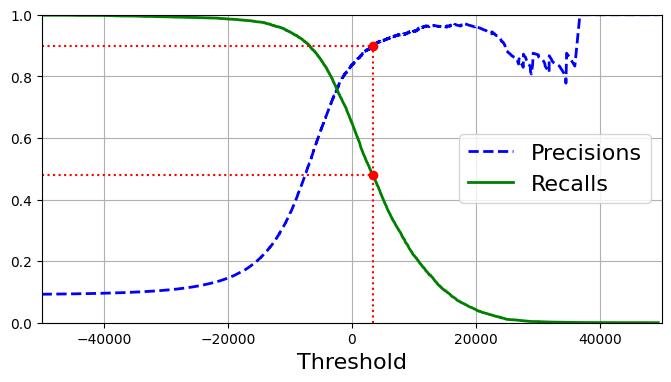

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precisions", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recalls", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown


recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
# save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

* 좋은 정밀도/재현율 트레이드오프를 선택하는 다른 방법
> * 재현율에 대한 정밀도 곡선 그리기

In [ ]:
(y_train_pred == (y_scores > 0)).all()

True

* PR 곡선
> * ROC 곡선과 비교해보자

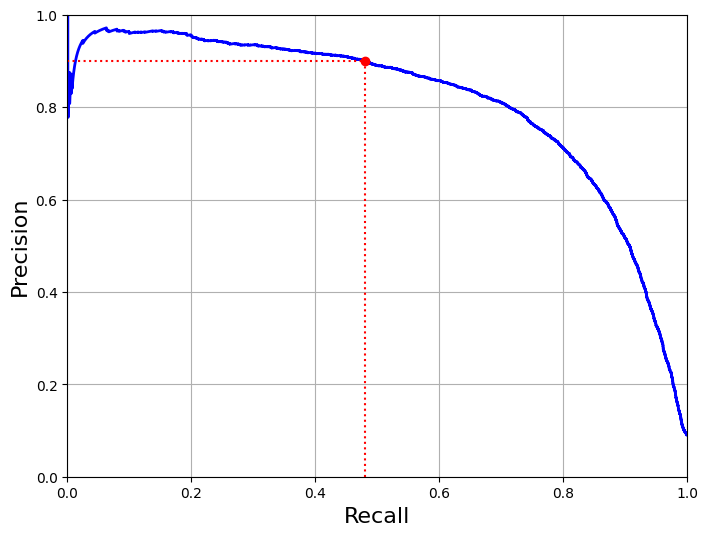

In [ ]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
# save_fig("precision_vs_recall_plot")
plt.show()

* PR 곡선이 오른쪽 위 모서리에 가까워질 수록 좋은 분류기이다
* 재현율 70% 부터 정밀도가 급격하게 줄어듬
* 이 하강점 직전을 정밀도/재현율 트레이드오프로 선택하는 것이 좋다. 예를 들어 재현율이 60% 정도인 지점
* 물론 이런 선택은 프로젝트에 따라 달라짐


* 빨간 점이 '최소한 90% 정밀도가 되는 가장 낮은 임곗값'이다

In [ ]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

* 훈련 세트에 대한 예측을 만들려면 분류기의 predict() 호출하는 대신 다음 코드를 실행

In [ ]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [ ]:
# 이 예측에 대한 정밀도와 재현율
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [ ]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

* 주의점! 재현율이 너무 낮다면 높은 정밀도의 분류기는 전혀 유용하지 않다
> * 누군가 "99% 정밀도를 달성하자" 라고 말하면 반드시 "재현율 얼마에서?" 라고 물어봐야 한다

* ROC 곡선
* 수신자 조작 특성(receiver operating characteristic, ROC) 곡선도 이진 분류에서 널리 사용하는 도구
> * 거짓 양성 비율(FPR)에 대한 진짜 양성 비율(TPR=재현율)의 곡선
  * 양성으로 잘못 분류된 음성 샘플의 비율이 FPR이고, FPR은 음성으로 정확하게 분류한 음성 샘플의 비율인 진짜 음성 비율(TNR)을 뺀 값이다
  * TNR = 특이도(specificity) 그러므로 ROC 곡선은 민감도(재현율=TPR)에 대한 1-특이도 그래프이다

* ROC 곡선을 그리려먼 먼저 roc_curve() 함수를 사용해 여러 임곗값에서 TPR과 FPR을 계산해야함

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

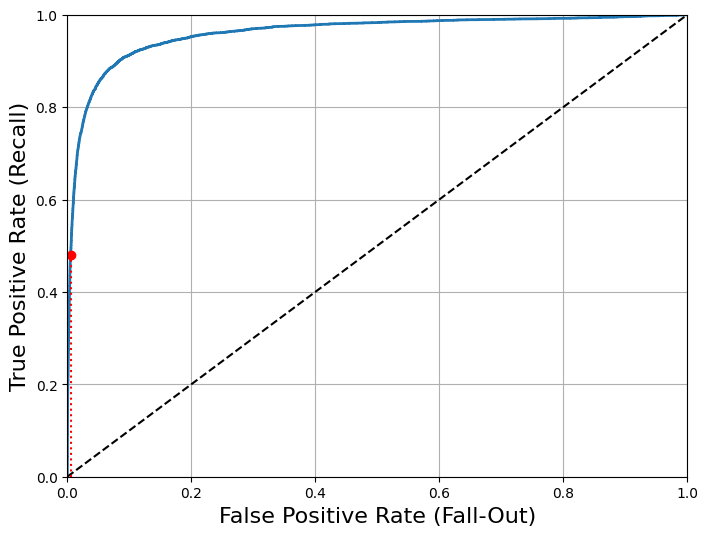

In [ ]:
# TPR에 대한 FPR 곡선
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # 대각 점선
    plt.axis([0, 1, 0, 1]) # 그래프의 축 범위                                 # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # 분류기가 90% 재현율을 달성하는 지점의 FPR
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
#save_fig("roc_curve_plot")                                    # Not shown
plt.show()

* 트레이드오프: 재현율(TPR)이 높을수록 분류기가 만드는 거짓 양성(FPR)이 늘어
* ROC 곡선 아래의 면적을 AUC(Area Under the Curve)라고 부르며, 이는 모델의 전반적인 성능을 측정하는 지표로 사용. AUC가 1에 가까울수록 좋은 모델을 의미하며, 0.5는 랜덤 추측 수준의 모델을, 0에 가까우면 최악의 모델을 의미함.

In [ ]:
# ROC의 AUC 계산하는 함수
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

* ROC 곡선과 PR 곡선의 비교
> * 일반적인 법칙은 양성클래스가 드물거나 거짓 음성보다 거짓 양성이 더 중요할 때 PR 곡선을 사용하고 그렇지 않으면 ROC 곡선을 사용
  * AUC 점수가 좋은 이유: 음성에 비해 양성이 크게 적기 때문
  * 그에비해 PR 곡선은 분류기의 성능 개선 여지가 얼마나 되는지 잘 보여준다

* 랜덤포레스트 이용해서 SGD와 점수 비교해보기
> * 훈련 세트의 샘플에 대한 점수 얻기
  * 랜덤포레스트는 decision_function()이 없다. 대신 predict_proba() 있다
  * 사이킷런 분류기는 일반적으로 이 두 메소드 중 하나 또는 둘 모두를 가지고 있다
  * predict_proba()는 샘플이 행, 클래스가 열이고 샘플이 주어진 클래스에 속할 확률을 담은 배열을 반환(예를 들어 어떤 이미지가 5일 확률 70%)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, 
                                    method='predict_proba')

* roc_curve()는 레이블과 점수를 기대. 하지만 점수 대신에 클래스 확률을 전달 가능하다

In [ ]:
# 양성 클래스에 대한 확률을 점수로 사용
y_scores_forest = y_probas_forest[:, 1] # 모든 양성 클래스에 대한 확률 선택
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

* 첫 번째 ROC 곡선과 함께 그리기

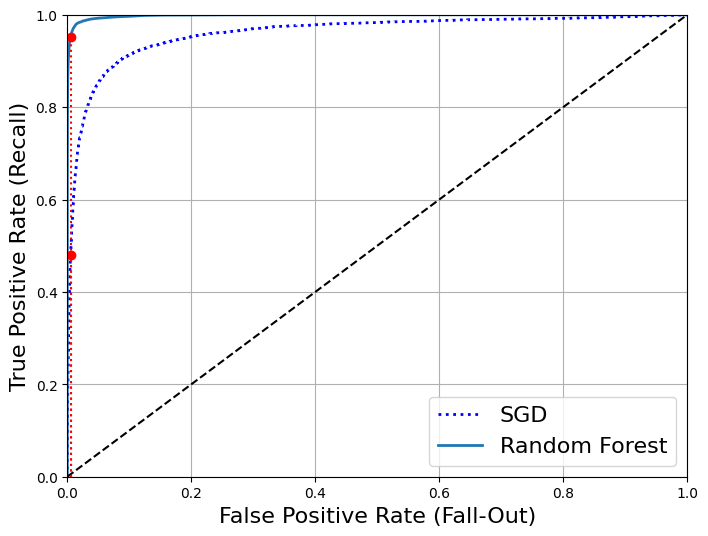

In [ ]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:") 
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
#save_fig("roc_curve_comparison_plot")
plt.show()

In [ ]:
# ROC AUC 점수
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [ ]:
# 랜덤포레스트 모델 정밀도
y_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, 
                                    method='predict')
precision_score(y_train_5, y_pred_forest)

0.9905083315756169

In [ ]:
# 랜덤포레스트 모델 재현율
recall_score(y_train_5, y_pred_forest)

0.8662608374838591

# 3.4 다중 분류

* 다중 분류기(multiclass classifier) 또는 다항 분류기는 둘 이상의 클래스를 구별 가능

* 일부 알고리즘(SGD, 랜덤 포레스트, 나이브 베이즈 naive Bayes)은 여러 개의 클래스를 직접 처리 가능, 반면 다른 알고리즘(로지스틱 회귀, 서포트 벡터 머신)은 이진 분류만 가능

* 하지만 이진 분류기를 여러 개 사용해 다중 클래스를 분류하는 기법도 많다
> * OvR 전략(one-versus-the-rest)또는  OvA(one-versus-all): 특정 숫자 하나만 구분하는 숫자별 이진 분류기 10개를 훈련시켜 클래스가 10개인 숫자 이미지 분류 시스템. 이미지를 분류할 때 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택
  * OvO(one-versus-one) 전략: 0과 1구별, 0과 2 구별, 1과 2 구별 등과 같이 각 숫자의 조합마다 이진 분류기를 훈련시키는 것. 클래스가 N개라면 분류기는 N*(N-1)/2개가 필요하다
   * 장점: 각 분류기의 훈련에 전체 훈련 세트 중 구별할 두 클래스에 해당하는 샘플만 필요하다는 것
   * 이러한 방식은 훈련 데이터셋의 크기에 민감한 알고리즘에 유리(SVM 같은), 작은 훈련 세트에서 많은 분류기를 훈련 시키는 쪽이 빠른 알고리즘
   * 하지만 대부분의 이진 분류 알고리즘에서는 OvR을 선호

* 다중 클래스 분류 작업에 이진 분류 알고리즘을 선택하면 사이킷런이 알고리즘에 따라 자동으로 OvR 또는 OvO를 실행

In [ ]:
# 서포트 벡터 머신 분류기 테스트해보자
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train) # y_train_5가 아니고 y_train을 사용
svm_clf.predict([some_digit])

array([5], dtype=uint8)

* OvO 전략을 사용했는지 확인해보자
* decision_function() 호출하면 샘플당 10개의 점수를 반환. 클래스마다 하나씩

In [ ]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [ ]:
np.argmax(some_digit_scores)

5

In [ ]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
svm_clf.classes_[5]

5

* 분류기가 훈련될 때 classes_ 속성에 타깃 클래스의 리스트를 값으로 정렬하여 저장. 위 예제에서는 classes_ 배열에 있는 각 클래스의 인덱스가 클래스 값 자체와 같다.
* 일반적으로 이런 경우는 드물다

* 강제로 OvO 또는 OvR 사용하도록 하기

In [ ]:
# SVC 기반으로 OvR전략 사용하는 다중 분류기(오래걸림)
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
len(ovr_clf.estimators_)

10

* SGDClassifier(또는 RandomForestClassifier)를 훈련

In [ ]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

* 위 경우는 SGD 분류기는 직접 샘플을 다중 클래스로 분류할 수 있기 때문에 OvR, OvO 적용할 필요가 없다

In [ ]:
# SGD 분류기가 클래스마다 부여한 점수 확인
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

* 분류기 평가해보기
* 분류기 평가에는 일반적으로 교차 검증을 사용함

In [ ]:
# SGDClassifier 정확도 평가(오래걸림)
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

* 입력 스케일 조정

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

# 3.5 에러 분석

* 가능성이 높은 모델을 하나 찾았다고 가정하고 이 모델의 성능을 향상시킬 방법을 찾아보자
* 한 가지 방법은 만들어진 에러의 종류를 분석하는 것

* 오차 행렬 살펴보자

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

* 오차 행렬을 이미지로 표현
* 행: 실제 클래스 나타냄
* 열: 예측한 클래스

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

* 대부분의 이미지가 올바르게 분류되었음을 나타내는 주대각선에 있으므로 매우 좋아 보인다
* 숫자 5는 다른 숫자보다 조금 더 어두워 보인다
> 1. 데이터셋에 숫자 5의 이미지가 적거나
  2. 분류기가 숫자 5를 다른 숫자만큼 잘 분류하지 못한다는 뜻
  * 두 경우 모두 확인해 봐야 함


* 에러 비율 비교
* 에러의 절대 개수를 비교하면 안됨

In [ ]:
# 각 행을 합하여 각 클래스의 총 개수를 계산
# keepdims=True: 결과를 같은 차원으로 유지하게 함
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

In [ ]:
np.fill_diagonal(norm_conf_mx, 0) # 주대각선 0으로 채우기
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

* 클래스 8의 열이 상당히 밝으므로 많은 이미지가 8로 잘못 분류되었음을 암시

* 8로 잘못 분류되는 것을 줄이도록 개선할 필요가 있다
> * 예를 들어 8처럼 보이는 하지만 실제 8은 아닌 숫자의 훈련 데이터를 더 많이 모아서 실제 8과 구분하도록 분류기를 학습하기
  * 또는 분류기에 도움 될 만한 특성을 찾기: 동심원의 수를 세는 알고리즘 같은 것
  * 또는 동심원 같은 어떤 패턴이 드러나도록 이미지 전처리하기

* 개개의 에러를 분석해보면 통찰을 얻을 수 있지만 더 어렵고 시간이 오래 걸린다

* 예를 들어 3과 5의 샘플을 그려보자

In [ ]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row) 와 동일합니다:
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가합니다:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성합니다:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합칩니다. 
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합칩니다:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력하면 됩니다:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

In [ ]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

* 대부분의 잘못 분류된 이미지는 분류기가 실수한 이유를 이해하기 어렵다
> * 원인은 선형 모델인 SGDClassifier를 사용했기 때문
  * 선형 분류기는 클래스마다 픽셀에 가중치를 할당하고 새로운 이미지에 대해 단순히 픽셀 강도의 가중치 합을 클래스의 점수로 계산. 따라서 3과 5는 몇 개의 픽셀만 다르기 때문에 모델이 쉽게 혼동함
  
* 3과 5의 주요 차이는 위쪽 선과 아래쪽 호를 이어주는 작은 직선의 위치
* 분류기는 이미지의 위치나 회전 방향에 매우 민감
* 3과 5의 에러를 줄이는 한 가지 방법: 이미지를 중앙에 위치시키고 회전되어 있지 않도록 전처리하는 것

# 3.6 다중 레이블 분류

* 다중 레이블 분류(multilabel classification) 시스템: 여러 개의 이진 꼬리표를 출력하는 분류 시스템

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)   # 7,8,9 = True
y_train_odd = (y_train % 2 == 1) # 홀수 = True
y_multilabel = np.c_[y_train_large, y_train_odd]
# np.c_ : 여러 개의 1차원 배열을 열 방향(세로 방향)으로 합쳐서
# 2차원 배열을 만들 때 사용

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

* 이 코드는 각 숫자 이미지에 두 개의 타깃 레이블이 담긴 y_multilabel 배열을 만듬

* KNeighborsClassifier는 다중 레이블 분류를 지원하지만 모든 분류기가 그런 것은 아니다
> * 다중 레이블 분류 지원하는 분류기: 결정 트리, 랜덤 포레스트, OneVsRestClassifier
* 이제 예측을 만들면 레이블 두 개 출력

In [ ]:
knn_clf.predict([some_digit])

* 다중 레이블 분류기 평가하기
* 프로젝트마다 다르다
* 다음 코드는 모든 레이블에 대한 F1 점수의 평균 계산

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

* 클래스 불균형 문제가 있을 경우(한 클래스의 샘플 수가 다른 클래스의 샘플 수에 비해 훨씬 많거나 적은 경우)
 * 간단한 방법: 레이블에 클래스의 지지도(support)를 가중치로 주는 것
 * average='weighted'로 바꾸기

# 3.7 다중 출력 분류

* 다중 출력 다중 클래스 분류(multioutput-multiclass classfification) 또는 다중 출력 분류(multioutput classification): 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것(즉, 값을 두 개 이상 가질 수 있다)

* 이를 위해 이미지에서 잡음을 제거하는 시스템을 만들어 보자
> * 잡음이 많은 숫자 이미지를 입력으로 
  받고 깨끗한 숫자 이미지를 MNIST 이미지처럼 픽셀의 강도를 담은 배열로 출력
  * 분류기의 출력이 다중 레이블(픽셀당 한 레이블)이고 각 레이블은 값을 여러 개 가짐(0~255까지의 픽셀 강도)
  * 그러므로 이 예는 다중 출력 분류 시스템이다

* 다중 출력 분류는 일반적으로 회귀와 분류를 결합한 작업으로, 다중 출력 회귀(multioutput regression)라고도 부름


* 먼저 MNIST 이미지에서 추출한 훈련 세트와 테스트 세트에 넘파이의 randint()함수를 사용해 픽셀 강도에 잡음을 추가
* 타깃 이미지는 원본 이미지가 될 것이다

In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))
# 0 이상 100 미만 정수 무작위 생성, 배열의 형태 (len(X_train), 784)
# len(X_train) : 훈련 샘플 개수, 784 : 각 이미지 픽셀 개수
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
# 테스트 세트에서 이미지 하나 선택
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")
    
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
#save_fig("noisy_digit_example_plot")
plt.show()

In [ ]:
# 분류기 훈련시켜 잡음 제거하기
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)